In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(1)
np.random.seed(1)

In [2]:
url='https://raw.githubusercontent.com/nzxtdata/Multivariate-Financial-Time-Series-Forecasting-with-Machine-Learning/main/FTSEfundamental.csv'
df1 = pd.read_csv(url, parse_dates= True)
df=df1.copy()
df.Date = pd.to_datetime(df.Date)
df.set_index("Date", inplace=True)
df = df[df.index.year <= 2020]
df=df.asfreq('b')
df=df.fillna(method='ffill')

In [3]:
df.shape

(6981, 10)

In [4]:
df['returns'] = df.ftseclose.pct_change(1).mul(100)
df = df.iloc[2:]

In [5]:
df.tail()

,ftseopen,ftsehigh,ftselow,ftseclose,ftsevolume,fwd_6mo_usd_to_gbp,10yr_treasury_yield,uk_gdp_qoq_cvm_sa_growth_%,uk_unemployment_sa_%,uk_longterm_ir_%,returns
Date,,,,,,,,,,,
2020-12-25,6495.799805,6530.299805,6479.600098,6502.100098,477470700.0,1.2374,0.8347,-19.5,3.8,0.303333,0.000000
2020-12-28,6495.799805,6530.299805,6479.600098,6502.100098,477470700.0,1.2374,0.8347,-19.5,3.8,0.303333,0.000000
2020-12-29,6502.100098,6676.600098,6502.100098,6602.700195,824116800.0,1.2374,0.8347,-19.5,3.8,0.303333,1.547194
2020-12-30,6602.700195,6623.000000,6552.500000,6555.799805,425493000.0,1.2374,0.8347,-19.5,3.8,0.303333,-0.710321
2020-12-31,6555.799805,6555.799805,6439.399902,6460.500000,316943900.0,1.2374,0.8347,-19.5,3.8,0.303333,-1.453672


In [6]:
df.describe()

,ftseopen,ftsehigh,ftselow,ftseclose,ftsevolume,fwd_6mo_usd_to_gbp,10yr_treasury_yield,uk_gdp_qoq_cvm_sa_growth_%,uk_unemployment_sa_%,uk_longterm_ir_%,returns
count,6979.000000,6979.000000,6979.000000,6979.000000,6.979000e+03,6979.000000,6979.000000,6979.000000,6979.000000,6979.000000,6979.000000
mean,5608.215646,5645.254092,5570.362805,5608.790828,8.899800e+08,1.579432,4.529172,0.068620,6.081258,4.118154,0.017004
std,1186.182847,1190.230071,1182.283103,1186.011929,6.025381e+08,0.174286,1.833678,2.796679,1.540816,2.187177,1.132194
min,2844.699951,2902.199951,2844.699951,2876.600098,0.000000e+00,1.237400,0.834700,-19.500000,3.700000,0.303333,-10.873819
25%,4764.550049,4800.849854,4730.250000,4763.000000,5.590956e+08,1.513700,3.507200,0.300000,4.900000,2.586967,-0.510400
50%,5831.500000,5869.200195,5782.700195,5832.500000,8.270311e+08,1.582100,4.465500,0.400000,5.500000,4.458034,0.009198
75%,6471.550049,6515.200195,6430.349854,6473.150146,1.305440e+09,1.665000,5.035700,0.700000,7.700000,5.311433,0.572185
max,7877.500000,7903.500000,7854.600098,7877.500000,4.420947e+09,1.962400,8.627300,1.700000,9.800000,8.693767,9.838667


In [7]:
df.columns

Index(['ftseopen', 'ftsehigh', 'ftselow', 'ftseclose', 'ftsevolume',
       'fwd_6mo_usd_to_gbp', '10yr_treasury_yield',
       'uk_gdp_qoq_cvm_sa_growth_%', 'uk_unemployment_sa_%',
       'uk_longterm_ir_%', 'returns'],
      dtype='object')

In [8]:
df.shape

(6979, 11)

In [9]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [10]:
validate = df[['ftseopen', 'ftsehigh', 'ftselow', 'ftseclose', 'ftsevolume',
       'fwd_6mo_usd_to_gbp', '10yr_treasury_yield',
       'uk_gdp_qoq_cvm_sa_growth_%', 'uk_unemployment_sa_%',
       'uk_longterm_ir_%','returns']].tail(20)
df.drop(df.tail(20).index,inplace=True)

In [11]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['ftseopen', 'ftsehigh', 'ftselow', 'ftseclose', 'ftsevolume',
       'fwd_6mo_usd_to_gbp', '10yr_treasury_yield',
       'uk_gdp_qoq_cvm_sa_growth_%', 'uk_unemployment_sa_%',
       'uk_longterm_ir_%','returns']])
dataY = y_scaler.fit_transform(df[['ftseclose']])

In [12]:
df.shape

(6959, 11)

In [13]:
hist_window = 100
horizon = 20
TRAIN_SPLIT = 6000
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [14]:
x_val_multi.shape

(839, 100, 11)

In [15]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.04802495 0.03683041 0.04824446 ... 1.         0.78039669 0.52498861]
 [0.04295818 0.04278887 0.04038006 ... 1.         0.78039669 0.57160434]
 [0.05923146 0.04862735 0.05686743 ... 1.         0.78039669 0.54869335]
 ...
 [0.0648148  0.05854479 0.06407313 ... 0.95081967 0.95041174 0.59095125]
 [0.0680933  0.05984445 0.0669674  ... 0.95081967 0.95041174 0.51333597]
 [0.06489431 0.05790496 0.06493144 ... 0.95081967 0.95041174 0.53833792]]

 Target horizon
[[0.05968926]
 [0.06570814]
 [0.0715071 ]
 [0.07768602]
 [0.07768602]
 [0.07458658]
 [0.0749265 ]
 [0.06796775]
 [0.06920751]
 [0.07296685]
 [0.06574813]
 [0.06544818]
 [0.06066906]
 [0.05253054]
 [0.05043091]
 [0.04895115]
 [0.04063268]
 [0.04721147]
 [0.03769322]
 [0.04049271]]


In [16]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [17]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train_multi.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=32,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_multi.shape[1]), 
    tf.keras.layers.LSTM(units=64,return_sequences=True),
    tf.keras.layers.LSTM(units=32,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])
ED_lstm_model.compile(optimizer='adam', loss='mse')


In [18]:
model_path = 'Encoder_Decoder_LSTM_Multivariate.h5'

In [19]:
model_path = 'Encoder_Decoder_LSTM_Multivariate.h5'
EVALUATION_INTERVAL = 100
EPOCHS = 100
history = ED_lstm_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                                  tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)
                              ]
                           )

Epoch 1/100
100/100 [==============================] - 58s 498ms/step - loss: 0.0777 - val_loss: 0.0678
Epoch 2/100
100/100 [==============================] - 48s 476ms/step - loss: 0.0353 - val_loss: 0.0442
Epoch 3/100
100/100 [==============================] - 48s 483ms/step - loss: 0.0146 - val_loss: 0.0302
Epoch 4/100
100/100 [==============================] - 49s 487ms/step - loss: 0.0077 - val_loss: 0.0224
Epoch 5/100
100/100 [==============================] - 49s 489ms/step - loss: 0.0050 - val_loss: 0.0147
Epoch 6/100
100/100 [==============================] - 48s 485ms/step - loss: 0.0034 - val_loss: 0.0098
Epoch 7/100
100/100 [==============================] - 48s 483ms/step - loss: 0.0028 - val_loss: 0.0109
Epoch 8/100
100/100 [==============================] - 48s 480ms/step - loss: 0.0054 - val_loss: 0.0090
Epoch 9/100
100/100 [==============================] - 48s 478ms/step - loss: 0.0034 - val_loss: 0.0271
Epoch 10/100
100/100 [==============================] - 48s 480m

In [20]:
Trained_model = tf.keras.models.load_model(model_path)

In [21]:
# Show the model architecture
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           19456     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 32)           12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 15)                2880      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 20, 15)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 64)            20480     
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 32)            12416     
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 1)             3

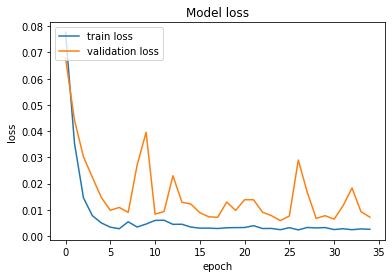

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [20,6]
plt.show()

In [23]:
data_val = x_scaler.fit_transform(df[['ftseopen', 'ftsehigh', 'ftselow', 'ftseclose', 'ftsevolume',
       'fwd_6mo_usd_to_gbp', '10yr_treasury_yield',
       'uk_gdp_qoq_cvm_sa_growth_%', 'uk_unemployment_sa_%',
       'uk_longterm_ir_%','returns']].tail(20))

val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

Predicted_results = Trained_model.predict(val_rescaled)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results.reshape(-1,1))

In [24]:
testing = validate[['ftseopen', 'ftsehigh', 'ftselow', 'ftseclose']].copy()
testing['pred'] = Predicted_results_Inv_trans

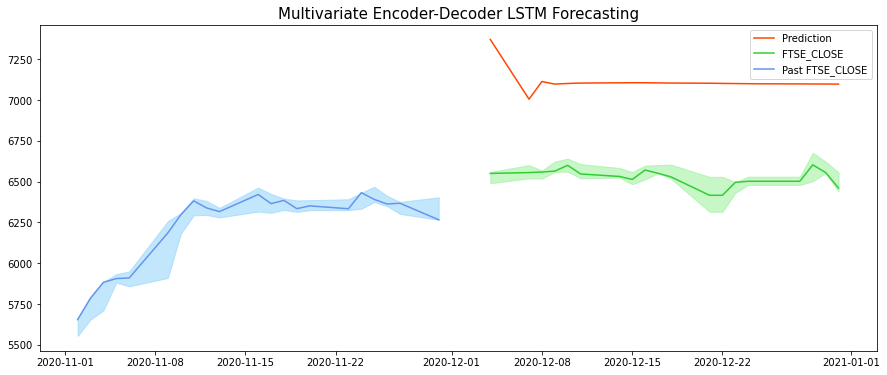

In [25]:
f, ax = plt.subplots(figsize=(15,6))

past = df[(df.index >= "2020-11-01") & (df.index < "2020-12-01")][['ftseclose', 'ftsehigh', 'ftselow']]
ax.plot(testing[['pred']], color = 'orangered', label='Prediction')
ax.plot(testing[['ftseclose']], color = 'limegreen', label='FTSE_CLOSE')
ax.plot(past[['ftseclose']], color = 'cornflowerblue', label='Past FTSE_CLOSE')


# ax.fill_between(test.ds, test.pred_lower, test.pred_upper, color='lightcoral', alpha=0.5)
ax.fill_between(testing.index, testing.ftselow, testing.ftsehigh, color='lightgreen', alpha=0.5)
ax.fill_between(past.index, past.ftselow, past.ftsehigh, color='lightskyblue', alpha=0.5)

ax.set_title("Multivariate Encoder-Decoder LSTM Forecasting", size = 15)
ax.legend()

plt.show()

In [26]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [27]:
timeseries_evaluation_metrics_func(testing['ftseclose'],testing['pred'])

Evaluation metric results:-
MSE is : 347440.98502157925
MAE is : 584.2102294921875
RMSE is : 589.4412481508053
MAPE is : 8.957689817361222
R2 is : -136.6639963245769



In [28]:
testing

,ftseopen,ftsehigh,ftselow,ftseclose,pred
Date,,,,,
2020-12-04,6490.299805,6559.200195,6489.799805,6550.200195,7370.577637
2020-12-07,6550.200195,6601.100098,6519.799805,6555.399902,7004.856445
2020-12-08,6555.399902,6567.600098,6518.399902,6558.799805,7112.959961
2020-12-09,6558.799805,6623.000000,6558.799805,6564.299805,7097.230469
2020-12-10,6564.299805,6640.700195,6561.100098,6599.799805,7101.031250
2020-12-11,6599.799805,6607.399902,6520.500000,6546.799805,7103.534180
2020-12-14,6546.799805,6583.700195,6524.700195,6531.799805,7105.164062
2020-12-15,6531.799805,6558.200195,6484.000000,6513.299805,7105.730469
2020-12-16,6513.299805,6598.399902,6513.299805,6570.899902,7105.461426


In [29]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [30]:
timeseries_evaluation_metrics_func(testing.ftseclose, testing.pred)

Evaluation metric results:-
MSE is : 347440.98502157925
MAE is : 584.2102294921875
RMSE is : 589.4412481508053
MAPE is : 8.957689817361222
R2 is : -136.6639963245769

